In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/MBTA_Model/MBTA_Bus_2024_Preprocessed.csv'
df = pd.read_csv(file_path, parse_dates=['service_date'])

<ipython-input-3-a5bcbbfdd2d6>:2: DtypeWarning: Columns (1,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['service_date'])


In [4]:
# Feature Engineering

df['rolling_delay_3'] = (
    df.sort_values('service_date')
      .groupby('route_id_str')['delay_minutes']
      .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
df['week_of_year'] = df['service_date'].dt.isocalendar().week
df['rush_hour_flag'] = df['scheduled_minutes'].apply(lambda x: 1 if 420 <= x <= 570 or 960 <= x <= 1110 else 0)

agg_df = df.groupby(['route_id_str', 'service_date'], as_index=False).agg({
    'delay_minutes': 'mean',
    'rolling_delay_3': 'mean',
    'is_holiday': 'first',
    'is_weekend': 'first',
    'temperature_max': 'mean',
    'precipitation': 'mean',
    'is_raining': 'first',
    'rush_hour_flag': 'mean',
    'week_of_year': 'first'
})

if 'on_time_flag' not in df.columns:
    df['on_time_flag'] = df['delay_minutes'] <= 5

daily_on_time = df.groupby(['route_id_str', 'service_date'])['on_time_flag'].mean().reset_index(name='on_time_pct')
agg_df = agg_df.merge(daily_on_time, on=['route_id_str', 'service_date'])

agg_df['route_cat'] = agg_df['route_id_str'].astype('category').cat.codes
agg_df['day_of_week'] = agg_df['service_date'].dt.dayofweek


In [5]:
# Feature Scaling

scaler = StandardScaler()
agg_df[['delay_minutes_scaled', 'rolling_delay_3_scaled', 'temperature_max_scaled', 'precipitation_scaled']] = scaler.fit_transform(
    agg_df[['delay_minutes', 'rolling_delay_3', 'temperature_max', 'precipitation']])

features = ['route_cat', 'day_of_week', 'week_of_year', 'delay_minutes_scaled', 'rolling_delay_3_scaled',
            'is_holiday', 'is_weekend', 'temperature_max_scaled', 'precipitation_scaled',
            'is_raining', 'rush_hour_flag']
target = 'on_time_pct'

X = agg_df[features]
y = agg_df[target]
agg_df['year_month'] = agg_df['service_date'].dt.to_period('M')
train_mask = agg_df['year_month'] < '2024-09'
test_mask = agg_df['year_month'] == '2024-09'

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]


In [6]:
# Hyperparameter Tuning

param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.03, 0.05],
    'max_depth': [4, 6],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [7]:
# Predict and evaluate

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nFinal XGBoost Evaluation (Time-Based Split)")
print(f"Best Params: {grid_search.best_params_}")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 : {r2:.4f}")


Final XGBoost Evaluation (Time-Based Split)
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.8}
MAE : 0.1065
RMSE: 0.1361
R^2 : 0.2654


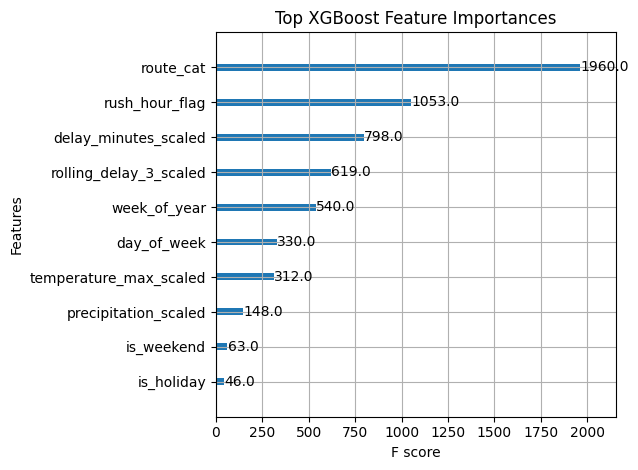

In [8]:
# Feature Importance

xgb.plot_importance(best_model, max_num_features=10)
plt.title("Top XGBoost Feature Importances")
plt.tight_layout()
plt.show()


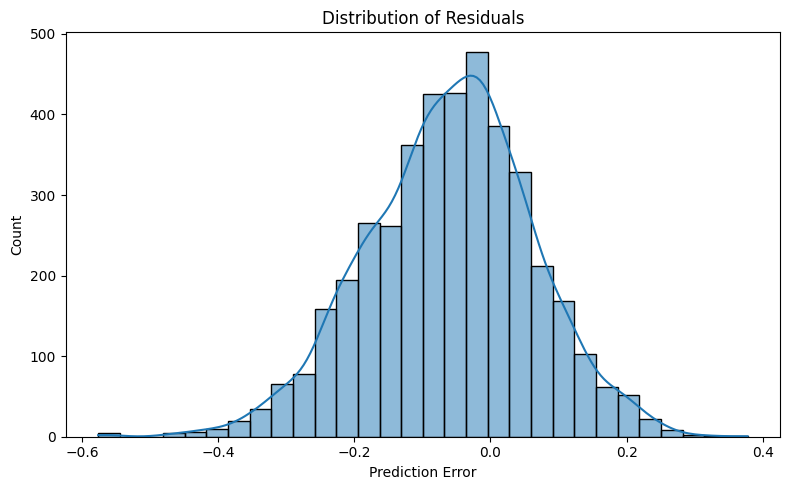

In [9]:
# Residual Plot

residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.tight_layout()
plt.show()

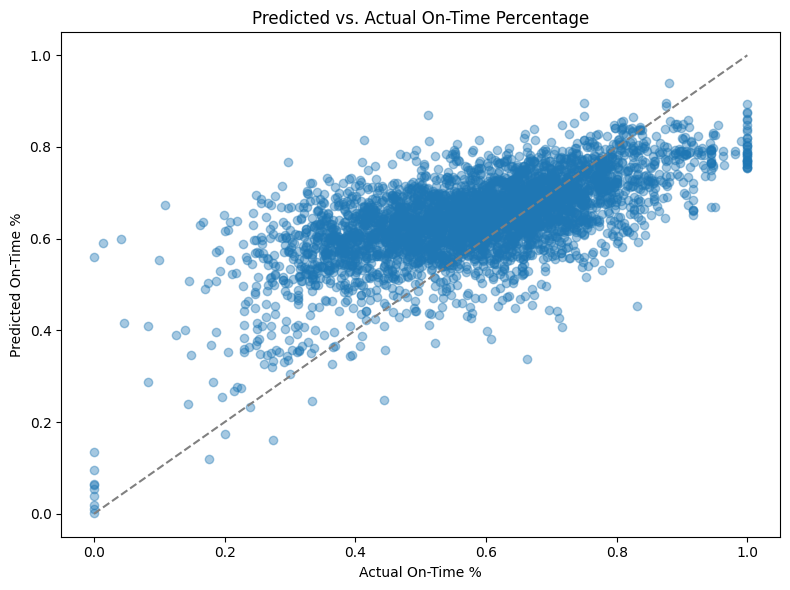

In [10]:
# Predictions vs. Actuals

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Actual On-Time %")
plt.ylabel("Predicted On-Time %")
plt.title("Predicted vs. Actual On-Time Percentage")
plt.tight_layout()
plt.show()


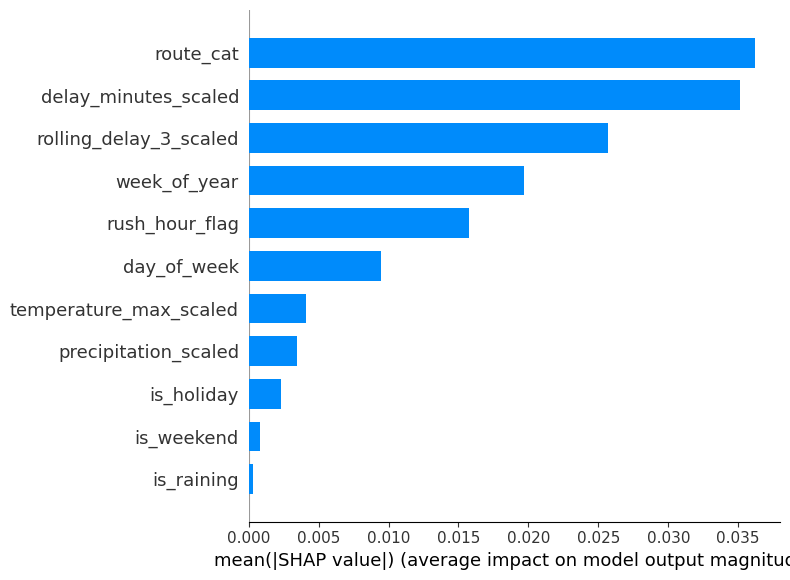

In [11]:
# SHAP Interpretability

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [13]:
# Baseline: Linear Regression

# Drop NaNs from training and test sets
X_train_clean = X_train.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

# Fit Linear Regression on cleaned data
lr = LinearRegression()
lr.fit(X_train_clean, y_train_clean)
y_lr_pred = lr.predict(X_test_clean)

print("\nLinear Regression Baseline")
print(f"MAE : {mean_absolute_error(y_test_clean, y_lr_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_clean, y_lr_pred)):.4f}")
print(f"R^2 : {r2_score(y_test_clean, y_lr_pred):.4f}")



Linear Regression Baseline
MAE : 0.1342
RMSE: 0.1705
R^2 : -0.1851


In [14]:
# Baseline: Dummy Regressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print("\nDummy Regressor Baseline")
print(f"R^2 : {r2_score(y_test, y_dummy):.4f}")


Dummy Regressor Baseline
R^2 : -0.1126


In [15]:
# TimeSeries Cross-Validation

tscv = TimeSeriesSplit(n_splits=5)
xgb_model_cv = xgb.XGBRegressor(**grid_search.best_params_)
scores = cross_val_score(xgb_model_cv, X, y, cv=tscv, scoring='r2')
print("\nTimeSeriesSplit R^2 scores:", scores)
print("Average R^2:", np.mean(scores))


TimeSeriesSplit R^2 scores: [0.46595549 0.28222859 0.20150548 0.23185847 0.27746743]
Average R^2: 0.29180309176807817
